In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, 
                             average_precision_score)
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, 
                                     Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

print("Modules loaded successfully!")
print(f"TensorFlow Version: {tf.__version__}")

Modules loaded successfully!
TensorFlow Version: 2.20.0


In [7]:
data_path = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train"

image_paths = []
labels_list = []

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, img_file))
            labels_list.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels_list})

In [8]:
print(f"Total Images: {len(df)}")
print(f"Number of Classes: {df['label'].nunique()}")
print("\nClass Distribution:")
class_dist = df['label'].value_counts()
print(class_dist)

Total Images: 1400
Number of Classes: 5

Class Distribution:
label
fukuyama_muscular_dystrophy         280
pachygyria_cerebellar_hypoplasia    280
walker_warburg_syndrome             280
moyamoya_disease                    280
hallervorden_spatz_disease          280
Name: count, dtype: int64


In [10]:
strat = df['label']
train_df, temp_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

strat = temp_df['label']
val_df, test_df = train_test_split(
    temp_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

print(f"Training Set: {train_df.shape[0]} images")
print(f"Validation Set: {val_df.shape[0]} images")
print(f"Test Set: {test_df.shape[0]} images")

print("\nClass Distribution in Splits:")
print("Train:", train_df['label'].value_counts().sum())
print("Validation:", val_df['label'].value_counts().sum())
print("Test:", test_df['label'].value_counts().sum())

Training Set: 1120 images
Validation Set: 140 images
Test Set: 140 images

Class Distribution in Splits:
Train: 1120
Validation: 140
Test: 140


In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")

print("\nDisplaying augmented images...")
augmented_images, augmented_labels = next(train_generator)

Found 1120 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.

Number of classes: 5
Class names: ['fukuyama_muscular_dystrophy', 'hallervorden_spatz_disease', 'moyamoya_disease', 'pachygyria_cerebellar_hypoplasia', 'walker_warburg_syndrome']

Displaying augmented images...


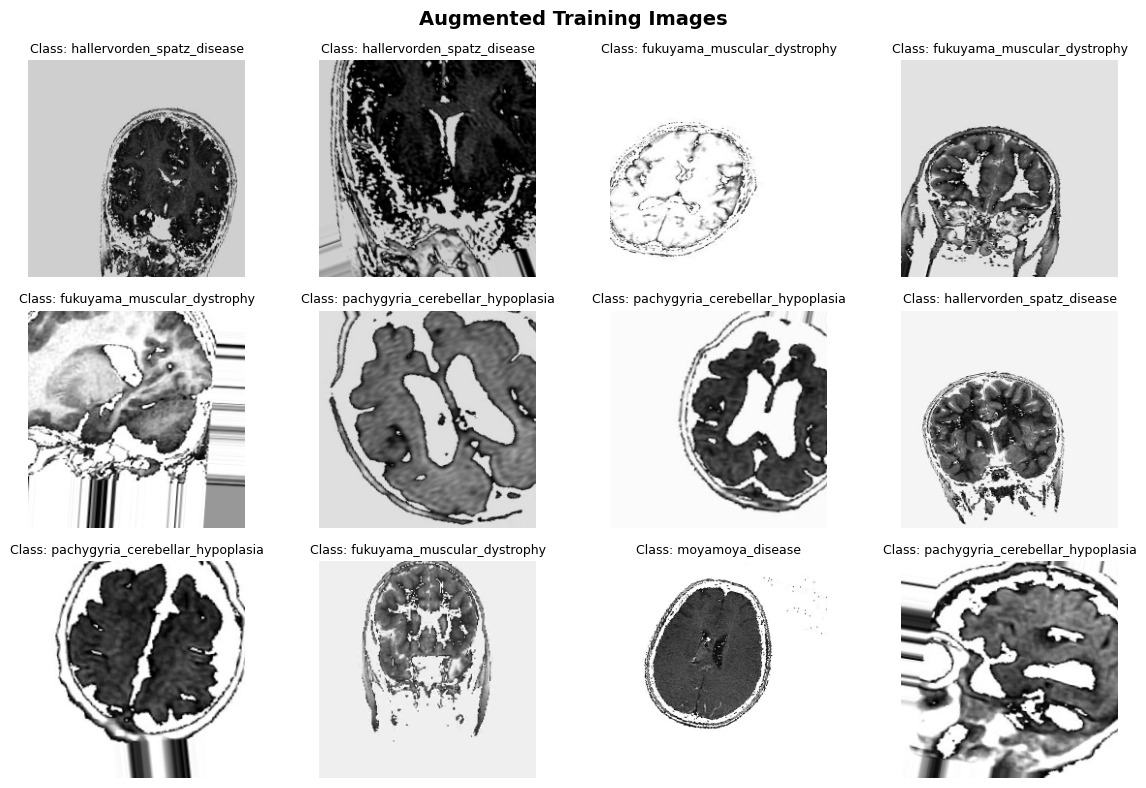

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[i])
    label_idx = np.argmax(augmented_labels[i])
    plt.title(f"Class: {class_names[label_idx]}", fontsize=9)
    plt.axis("off")

plt.suptitle("Augmented Training Images", fontsize=14, fontweight="bold")
plt.tight_layout()

plt.savefig("augmented_images.png", dpi=300, bbox_inches="tight") 
plt.show() 

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = True

for layer in base_model.layers[:15]: 
    layer.trainable = False
for layer in base_model.layers[15:]: 
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_vgg16_tf_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(
    train_generator,  
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2907 - loss: 1.8168

35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.3920 - loss: 1.5220 - val_accuracy: 0.2214 - val_loss: 1.4474 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6755 - loss: 0.9065

35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.7089 - loss: 0.8307 - val_accuracy: 0.5929 - val_loss: 1.0969 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8288 - loss: 0.6003

35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.8241 - loss: 0.5790 - val_accuracy: 0.6643 - val_loss: 0.9459 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8676 - loss: 0.4207

35/35 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8679 - loss: 0.4190 - val_accuracy: 0.6714 - val_loss: 0.7282 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9019 - loss: 0.3161

35/35 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9036 - loss: 0.3232 - val_accuracy: 0.8214 - val_loss: 0.5238 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9054 - loss: 0.2947

35/35 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.9232 - loss: 0.2518 - val_accuracy: 0.9500 - val_loss: 0.3014 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9571 - loss: 0.1654

35/35 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.9500 - loss: 0.1760 - val_accuracy: 0.9643 - val_loss: 0.1808 - learning_rate: 1.0000e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.9670 - loss: 0.1302 - val_accuracy: 0.8929 - val_loss: 0.2714 - learning_rate: 1.0000e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9623 - loss: 0.1142

35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9679 - loss: 0.1130 - val_accuracy: 0.9714 - val_loss: 0.1078 - learning_rate: 1.0000e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.9732 - loss: 0.0902 - val_accuracy: 0.9714 - val_loss: 0.1017 - learning_rate: 1.0000e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.9875 - loss: 0.0558 - val_accuracy: 0.9643 - val_loss: 0.0991 - learning_rate: 1.0000e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9846 - loss: 0.0546

35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9812 - loss: 0.0567 - val_accuracy: 0.9786 - val_loss: 0.0936 - learning_rate: 1.0000e-04
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9786 - loss: 0.0659 - val_accuracy: 0.9571 - val_loss: 0.1232 - learning_rate: 1.0000e-04
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9795 - loss: 0.0670 - val_accuracy: 0.9571 - val_loss: 0.1334 - learning_rate: 1.0000e-04
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9830 - loss: 0.0612 - val_accuracy: 0.9786 - val_loss: 0.0718 - learning_rate: 1.0000e-04
Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.9875 - loss: 0.0379 - val_accuracy: 0.9571 - val_loss: 0.1433 - learning_rate: 1.0000e-04
Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9852 - loss: 0.0585

35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9848 - loss: 0.0519 - val_accuracy: 0.9857 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 18/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.9929 - loss: 0.0313 - val_accuracy: 0.9857 - val_loss: 0.0451 - learning_rate: 1.0000e-04
Epoch 19/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9970 - loss: 0.0211

35/35 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.9973 - loss: 0.0186 - val_accuracy: 0.9929 - val_loss: 0.0217 - learning_rate: 1.0000e-04
Epoch 20/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9920 - loss: 0.0230 - val_accuracy: 0.9786 - val_loss: 0.0697 - learning_rate: 1.0000e-04
Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9893 - loss: 0.0355 - val_accuracy: 0.9643 - val_loss: 0.0860 - learning_rate: 1.0000e-04
Epoch 22/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.9830 - loss: 0.0411 - val_accuracy: 0.9929 - val_loss: 0.0218 - learning_rate: 1.0000e-04
Epoch 23/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.9875 - loss: 0.0350 - val_accuracy: 0.8714 - val_loss: 0.3679 - learning_rate: 1.0000e-04
Epoch 24/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9893 - loss: 0.0358
Epoch 24: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
35/35 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.9866 - loss: 0.04

Validation Accuracy: 0.9929
Validation Loss: 0.0217
Test Accuracy: 0.9857
Test Loss: 0.0454


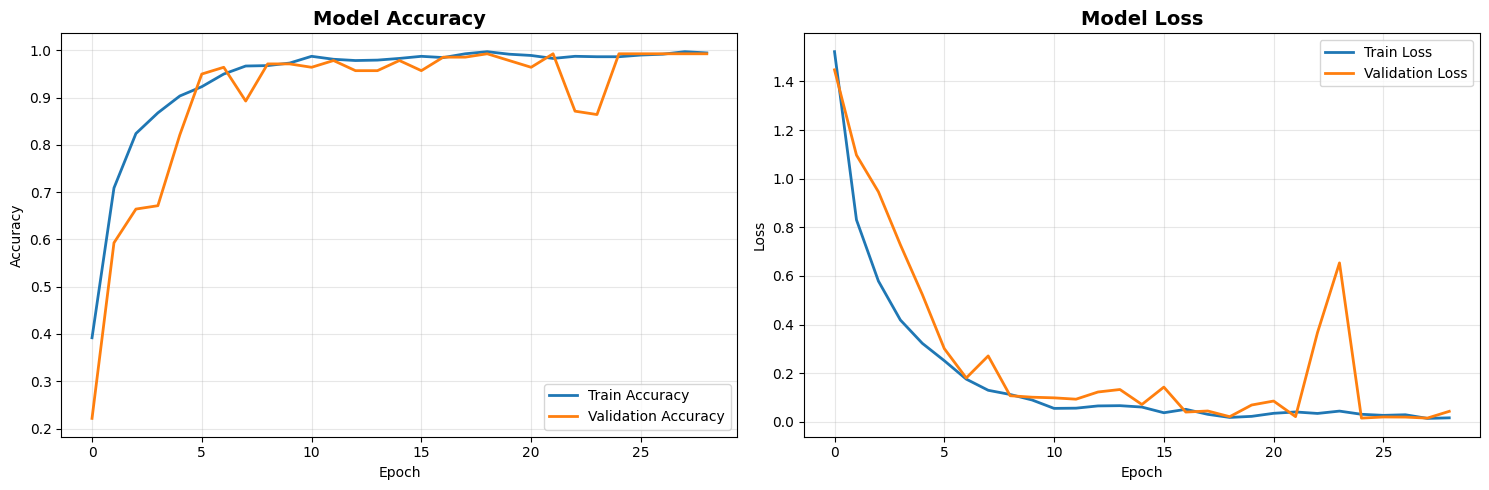

In [18]:
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
test_generator.reset()
y_true = []
y_pred = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    batch_pred = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(batch_pred, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nDetailed Classification Report:")
print("-" * 60)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

print("\nPer-Class Metrics:")
print("-" * 60)
cm = confusion_matrix(y_true, y_pred)
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{class_name:<20}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


Detailed Classification Report:
------------------------------------------------------------
                                  precision    recall  f1-score   support

     fukuyama_muscular_dystrophy     1.0000    0.9643    0.9818        28
      hallervorden_spatz_disease     1.0000    0.9643    0.9818        28
                moyamoya_disease     1.0000    1.0000    1.0000        28
pachygyria_cerebellar_hypoplasia     0.9333    1.0000    0.9655        28
         walker_warburg_syndrome     1.0000    1.0000    1.0000        28

                        accuracy                         0.9857       140
                       macro avg     0.9867    0.9857    0.9858       140
                    weighted avg     0.9867    0.9857    0.9858       140


Per-Class Metrics:
------------------------------------------------------------
fukuyama_muscular_dystrophy: Precision=1.0000, Recall=0.9643, F1=0.9818
hallervorden_spatz_disease: Precision=1.0000, Recall=0.9643, F1=0.9818
moyamoya_dise

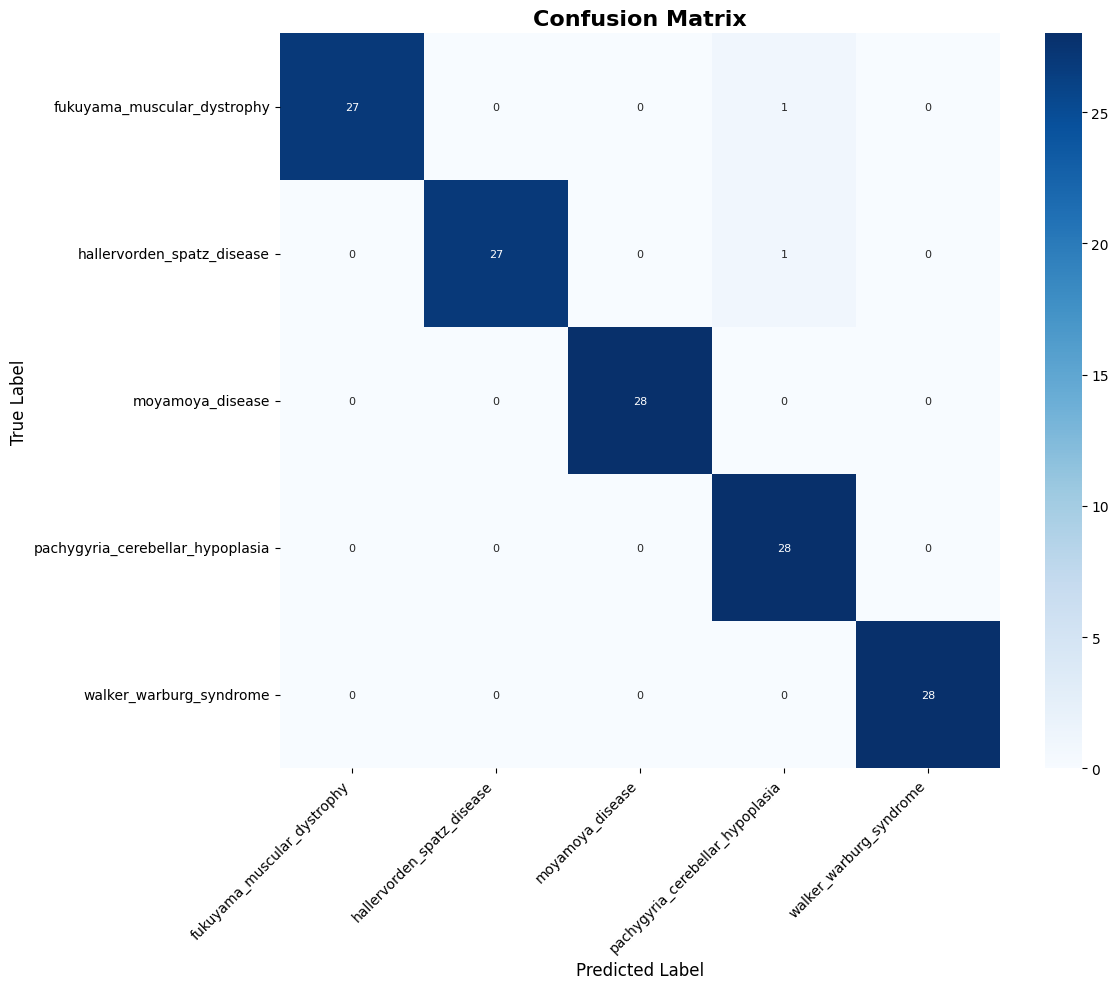

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={'size': 8})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

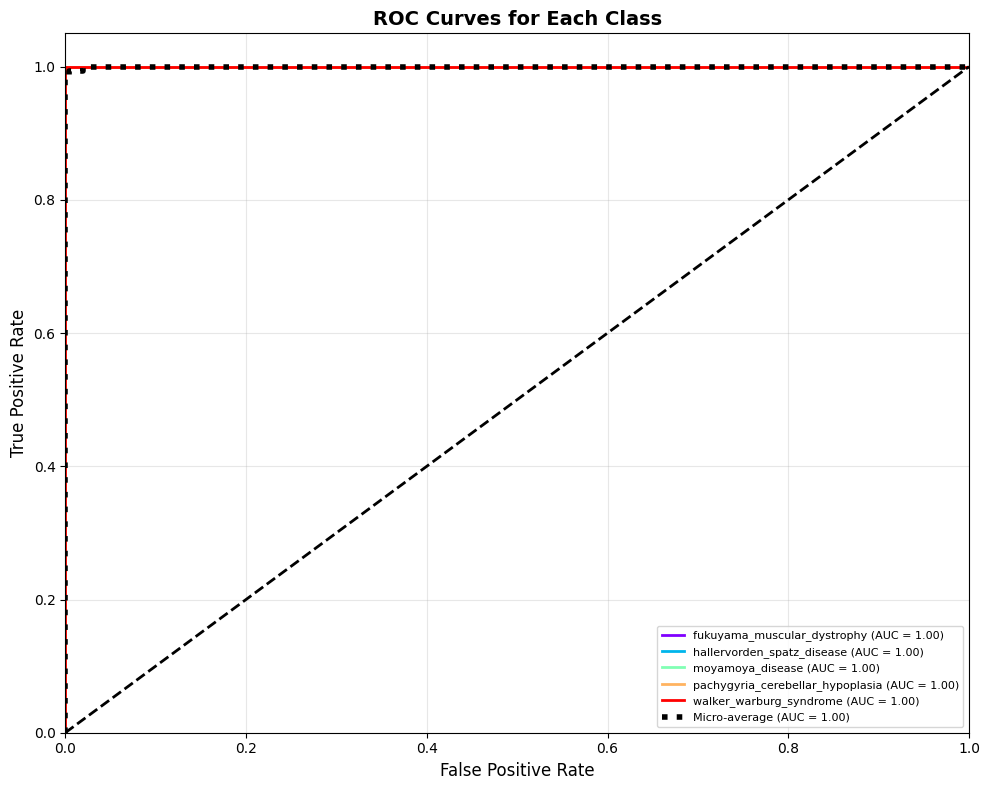


Average AUC Score: 1.0000


In [22]:
test_generator.reset()
y_true_probs = []
y_pred_probs = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_true_probs.append(y_batch)
    batch_pred_probs = model.predict(X_batch, verbose=0)
    y_pred_probs.append(batch_pred_probs)

y_true_probs = np.vstack(y_true_probs)
y_pred_probs = np.vstack(y_pred_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_probs[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_probs.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, min(num_classes, 10)))

for i, color in zip(range(min(num_classes, 10)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='black', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Each Class', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\nAverage AUC Score: {np.mean(list(roc_auc.values())[:num_classes]):.4f}")

Using VGG16 layer: 'block5_conv3'

Generating GradCAM visualizations...


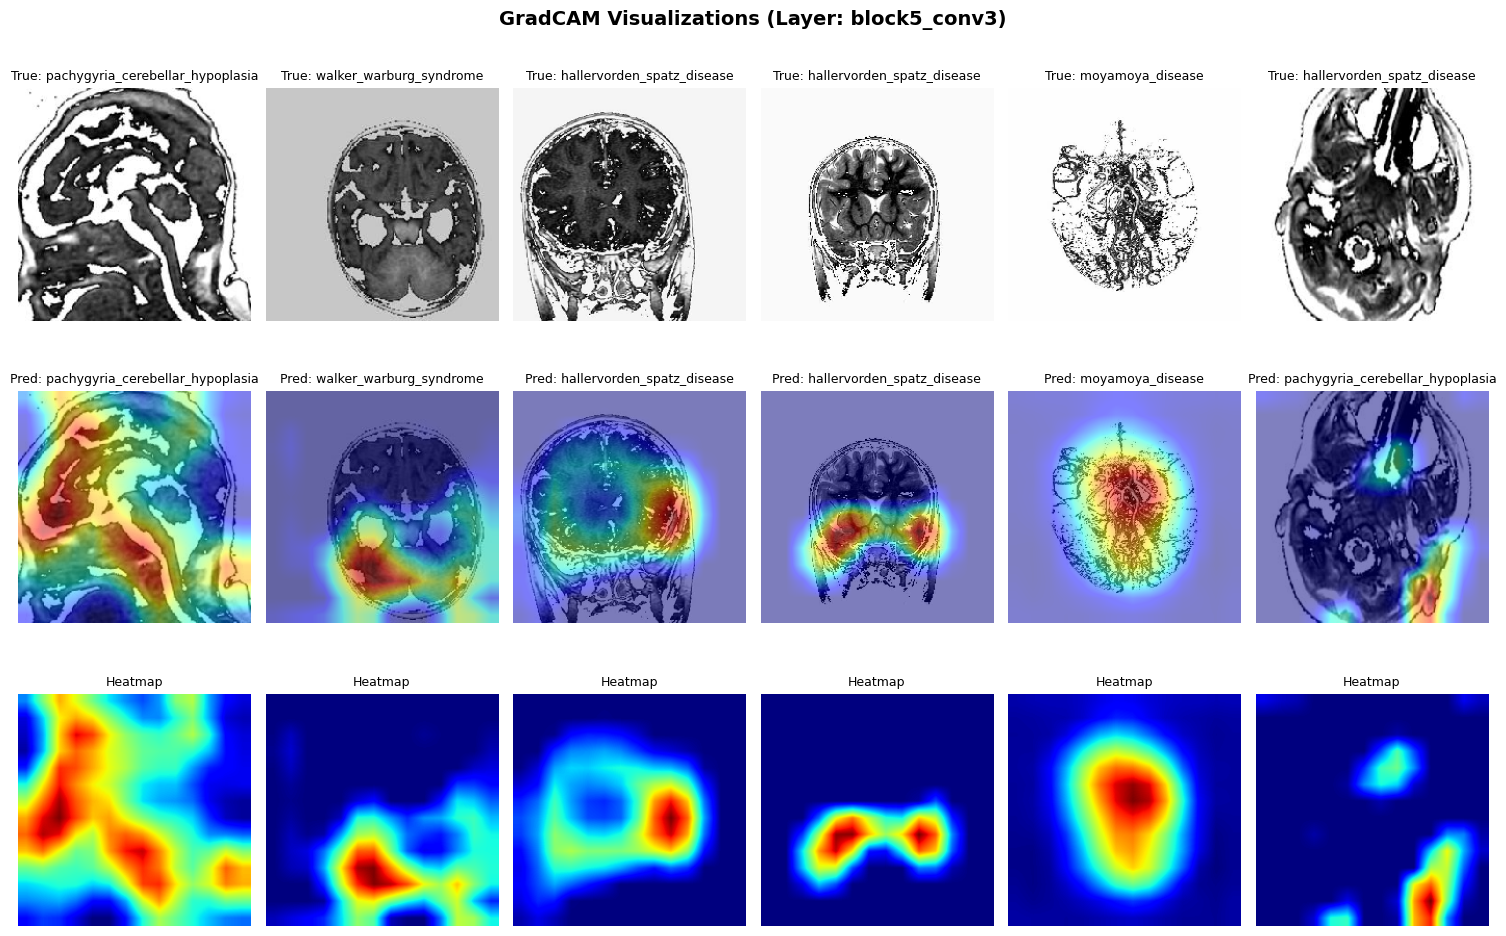

In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

test_generator.reset()
sample_images, sample_labels = next(test_generator)

vgg16_conv_layers = [
    'block1_conv1', 'block1_conv2',           
    'block2_conv1', 'block2_conv2',           
    'block3_conv1', 'block3_conv2', 'block3_conv3',  
    'block4_conv1', 'block4_conv2', 'block4_conv3',  
    'block5_conv1', 'block5_conv2', 'block5_conv3'   
]

last_conv_layer_name = 'block5_conv3'
print(f"Using VGG16 layer: '{last_conv_layer_name}'")
print("\nGenerating GradCAM visualizations...")

plt.figure(figsize=(15, 10))
for i in range(min(6, len(sample_images))):
    plt.subplot(3, 6, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_names[np.argmax(sample_labels[i])]
    plt.title(f"True: {true_label}", fontsize=9)
    plt.axis('off')
    
    img_array = np.expand_dims(sample_images[i], axis=0)
    
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        
        heatmap = np.uint8(255 * heatmap)
        heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), IMG_SIZE).numpy().squeeze()
        
        plt.subplot(3, 6, i + 7)
        plt.imshow(sample_images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        pred_label = class_names[np.argmax(model.predict(img_array, verbose=0)[0])]
        plt.title(f"Pred: {pred_label}", fontsize=9)
        plt.axis('off')
        
        plt.subplot(3, 6, i + 13)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Heatmap", fontsize=9)
        plt.axis('off')
        
    except Exception as e:
        print(f"Warning: Could not generate GradCAM for image {i}: {str(e)}")
        try:
            last_conv_layer_name = 'block4_conv3'
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            heatmap = np.uint8(255 * heatmap)
            heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), IMG_SIZE).numpy().squeeze()
            
            plt.subplot(3, 6, i + 7)
            plt.imshow(sample_images[i])
            plt.imshow(heatmap, cmap='jet', alpha=0.5)
            pred_label = class_names[np.argmax(model.predict(img_array, verbose=0)[0])]
            plt.title(f"Pred: {pred_label} (Layer: block4)", fontsize=8)
            plt.axis('off')
            
            plt.subplot(3, 6, i + 13)
            plt.imshow(heatmap, cmap='jet')
            plt.title("Heatmap (block4)", fontsize=8)
            plt.axis('off')
            
        except:
            plt.subplot(3, 6, i + 7)
            plt.imshow(sample_images[i])
            plt.title("GradCAM Failed", fontsize=8, color='red')
            plt.axis('off')
            
            plt.subplot(3, 6, i + 13)
            plt.text(0.5, 0.5, "Error", ha='center', va='center', fontsize=10, color='red')
            plt.axis('off')

plt.suptitle(f'GradCAM Visualizations (Layer: {last_conv_layer_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("gradcam_visualizations.png", dpi=300, bbox_inches="tight")
plt.show()

Using layer 'block5_conv3' for GradCAM


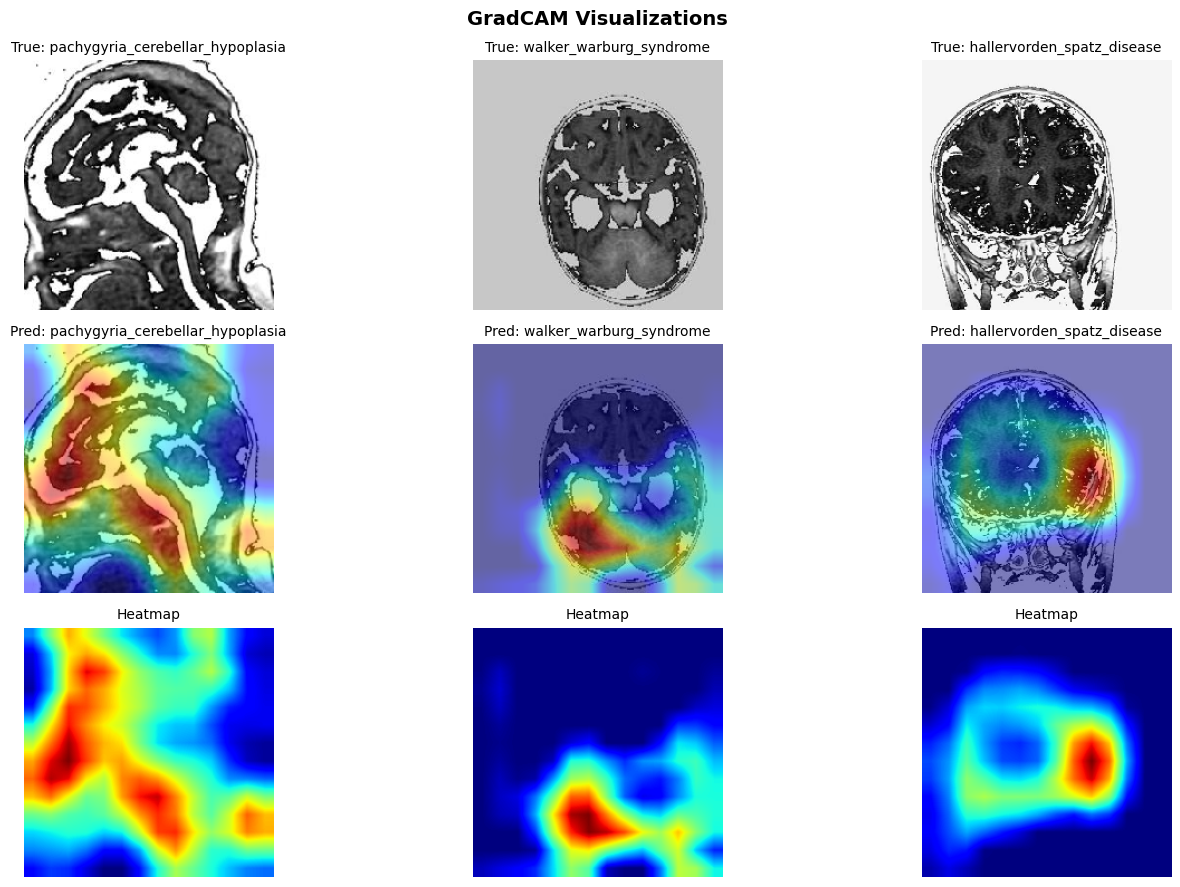

In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

test_generator.reset()
sample_images, sample_labels = next(test_generator)

last_conv_layer_name = 'block5_conv3'
print(f"Using layer '{last_conv_layer_name}' for GradCAM")

plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_names[np.argmax(sample_labels[i])]
    plt.title(f"True: {true_label}", fontsize=10)
    plt.axis('off')
    
    img_array = np.expand_dims(sample_images[i], axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), IMG_SIZE).numpy().squeeze()
    
    plt.subplot(3, 3, i + 4)
    plt.imshow(sample_images[i])
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    pred_label = class_names[np.argmax(model.predict(img_array, verbose=0)[0])]
    plt.title(f"Pred: {pred_label}", fontsize=10)
    plt.axis('off')
    
    plt.subplot(3, 3, i + 7)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Heatmap", fontsize=10)
    plt.axis('off')

plt.suptitle('GradCAM Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("gradcam_visualizations.png", dpi=300, bbox_inches="tight")
plt.show()


Generating Saliency Maps...


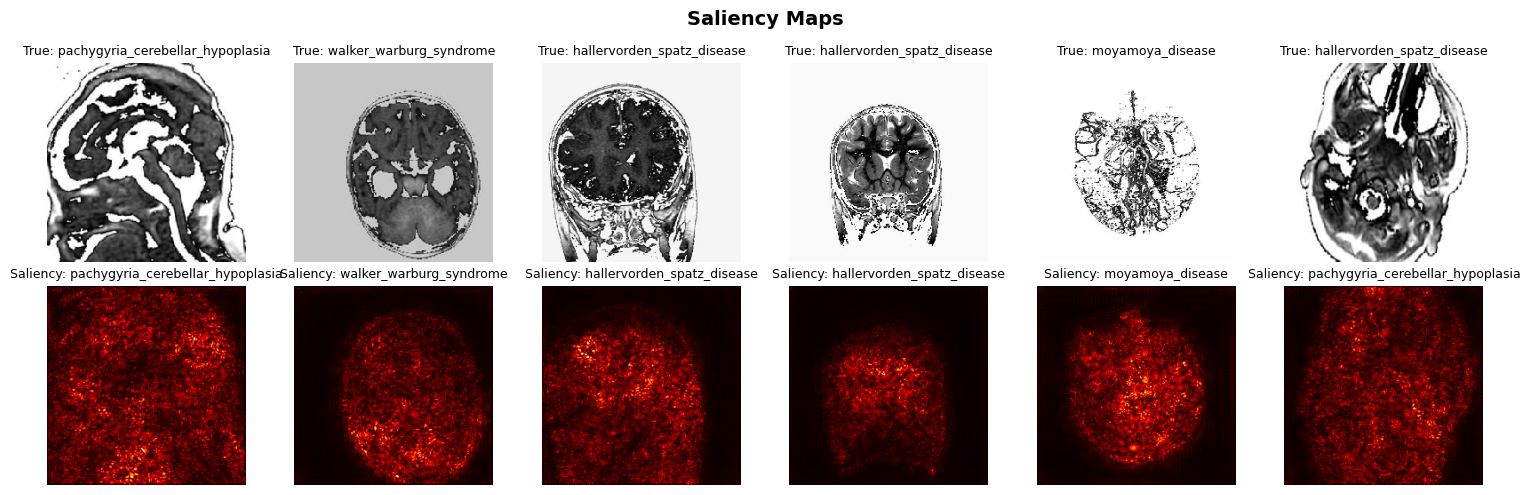

In [25]:
def generate_saliency_map(model, image, class_idx):
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        loss = predictions[:, class_idx]
    
    gradients = tape.gradient(loss, image_tensor)
    gradients = tf.reduce_max(tf.abs(gradients), axis=-1)
    gradients = gradients[0].numpy()
    
    if gradients.max() > gradients.min():
        gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
    
    return gradients

print("\nGenerating Saliency Maps...")

plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_names[np.argmax(sample_labels[i])]
    plt.title(f"True: {true_label}", fontsize=9)
    plt.axis('off')
    
    plt.subplot(2, 6, i + 7)
    pred_idx = np.argmax(model.predict(np.expand_dims(sample_images[i], axis=0), verbose=0)[0])
    saliency = generate_saliency_map(model, sample_images[i], pred_idx)
    plt.imshow(saliency, cmap='hot')
    pred_label = class_names[pred_idx]
    plt.title(f"Saliency: {pred_label}", fontsize=9)
    plt.axis('off')

plt.suptitle('Saliency Maps', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("saliency_maps.png", dpi=300, bbox_inches="tight")
plt.show()

Generating Saliency Maps...


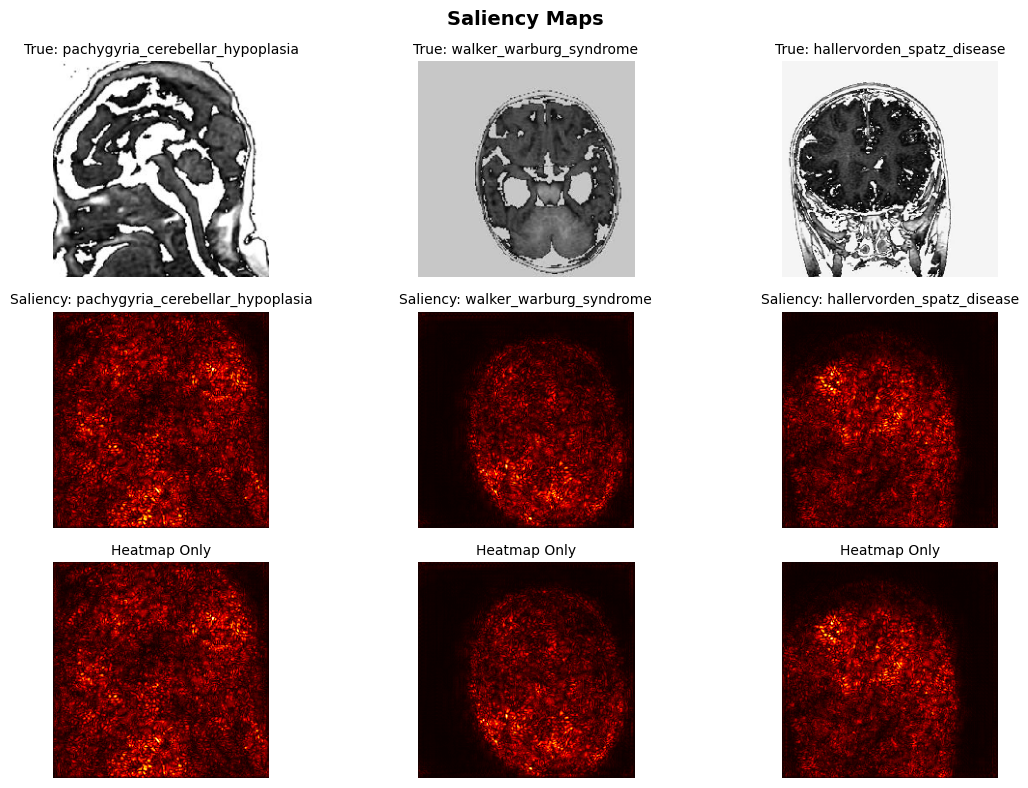

In [26]:
def generate_saliency_map(model, image, class_idx):
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        loss = predictions[:, class_idx]
    
    gradients = tape.gradient(loss, image_tensor)
    gradients = tf.reduce_max(tf.abs(gradients), axis=-1)
    gradients = gradients[0].numpy()
    
    if gradients.max() > gradients.min():
        gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
    
    return gradients

print("Generating Saliency Maps...")

plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_names[np.argmax(sample_labels[i])]
    plt.title(f"True: {true_label}", fontsize=10)
    plt.axis('off')
    
    plt.subplot(3, 3, i + 4)
    pred_idx = np.argmax(model.predict(np.expand_dims(sample_images[i], axis=0), verbose=0)[0])
    saliency = generate_saliency_map(model, sample_images[i], pred_idx)
    plt.imshow(saliency, cmap='hot')
    pred_label = class_names[pred_idx]
    plt.title(f"Saliency: {pred_label}", fontsize=10)
    plt.axis('off')
    
    plt.subplot(3, 3, i + 7)
    plt.imshow(saliency, cmap='hot')
    plt.title("Heatmap Only", fontsize=10)
    plt.axis('off')

plt.suptitle('Saliency Maps', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("saliency_maps.png", dpi=300, bbox_inches="tight")
plt.show()

In [27]:
model.save('vgg16.h5')

Generating GradCAM++ visualizations...


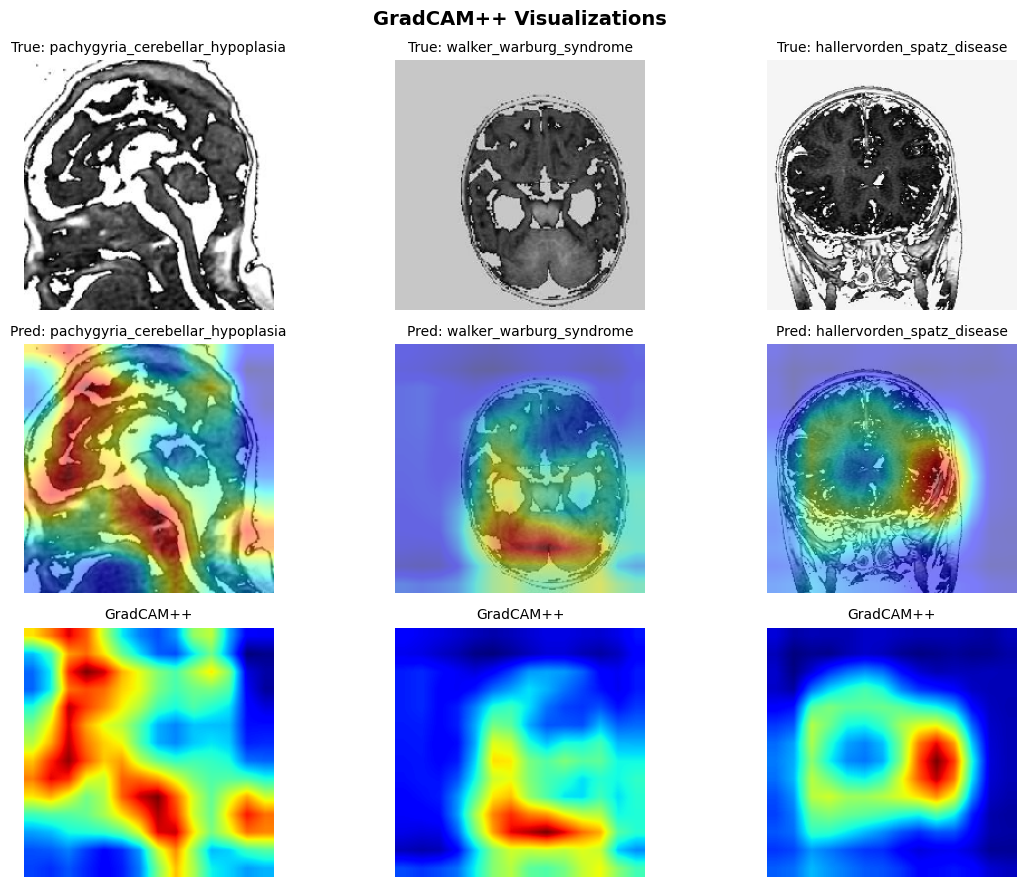

In [ ]:
def make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    grads_square = grads * grads
    grads_cube = grads_square * grads
    
    global_sum = tf.reduce_sum(last_conv_layer_output, axis=(1, 2), keepdims=True)
    
    alpha_num = grads_square
    alpha_denom = 2 * grads_square + global_sum * grads_cube
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom) * 1e-7)
    
    alphas = alpha_num / alpha_denom
    
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))
    cam = tf.reduce_sum(weights * last_conv_layer_output, axis=-1)
    
    cam = tf.nn.relu(cam)
    heatmap = cam / (tf.reduce_max(cam) + 1e-7)
    
    del tape
    return heatmap[0].numpy()

print("Generating GradCAM++ visualizations...")

plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_names[np.argmax(sample_labels[i])]
    plt.title(f"True: {true_label}", fontsize=10)
    plt.axis('off')
    
    img_array = np.expand_dims(sample_images[i], axis=0)
    heatmap_plus = make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name)
    
    heatmap_plus = np.uint8(255 * heatmap_plus)
    heatmap_plus = tf.image.resize(np.expand_dims(heatmap_plus, axis=-1), IMG_SIZE).numpy().squeeze()
    
    plt.subplot(3, 3, i + 4)
    plt.imshow(sample_images[i])
    plt.imshow(heatmap_plus, cmap='jet', alpha=0.5)
    pred_label = class_names[np.argmax(model.predict(img_array, verbose=0)[0])]
    plt.title(f"Pred: {pred_label}", fontsize=10)
    plt.axis('off')
    
    plt.subplot(3, 3, i + 7)
    plt.imshow(heatmap_plus, cmap='jet')
    plt.title("GradCAM++", fontsize=10)
    plt.axis('off')

plt.suptitle('GradCAM++ Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("gradcam_plus_plus_visualizations.png", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
import sys
!{sys.executable} -m pip install numba llvmlite
!{sys.executable} -m pip install shap --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 19.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [numba]32m1/2 [numba]

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.0/556.0 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [shap]2/5 [numpy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy

PartitionExplainer explainer: 2it [06:21, 381.02s/it]              


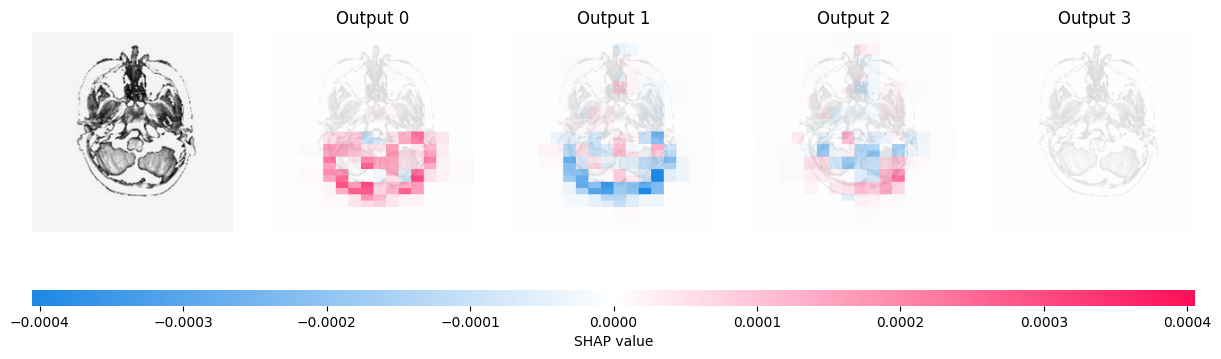

In [37]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train"

image_path = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train/fukuyama_muscular_dystrophy/fukuyama_muscular_dystrophy_train_0000.jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/Users/praneetgogoi/Documents/brain-mri-model/vgg16.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(150,150)", shape=(224, 224, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=5000, outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values_fine)

In [40]:
!{sys.executable} -m pip install lime

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.3 MB/s eta 0:00:00 0:00:01
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)
  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel fo

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


  1%|          | 10/1000 [00:00<01:09, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  2%|▏         | 20/1000 [00:01<01:02, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  3%|▎         | 30/1000 [00:01<01:00, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  4%|▍         | 40/1000 [00:02<00:58, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


  5%|▌         | 50/1000 [00:03<00:58, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


  6%|▌         | 60/1000 [00:03<00:57, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


  7%|▋         | 70/1000 [00:04<00:57, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


  8%|▊         | 80/1000 [00:04<00:57, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


  9%|▉         | 90/1000 [00:05<00:57, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 10%|█         | 100/1000 [00:06<00:56, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 11%|█         | 110/1000 [00:06<00:56, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 12%|█▏        | 120/1000 [00:07<00:55, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 13%|█▎        | 130/1000 [00:08<00:55, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 14%|█▍        | 140/1000 [00:08<00:54, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 15%|█▌        | 150/1000 [00:09<00:54, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 16%|█▌        | 160/1000 [00:10<00:54, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 17%|█▋        | 170/1000 [00:10<00:53, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 18%|█▊        | 180/1000 [00:11<00:53, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 19%|█▉        | 190/1000 [00:12<00:52, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 20%|██        | 200/1000 [00:12<00:52, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 21%|██        | 210/1000 [00:13<00:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 22%|██▏       | 220/1000 [00:14<00:51, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 23%|██▎       | 230/1000 [00:14<00:50, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 24%|██▍       | 240/1000 [00:15<00:50, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 25%|██▌       | 250/1000 [00:16<00:49, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 26%|██▌       | 260/1000 [00:16<00:48, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 27%|██▋       | 270/1000 [00:17<00:48, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 28%|██▊       | 280/1000 [00:18<00:47, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 29%|██▉       | 290/1000 [00:18<00:47, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 30%|███       | 300/1000 [00:19<00:46, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 31%|███       | 310/1000 [00:20<00:45, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 32%|███▏      | 320/1000 [00:20<00:45, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 33%|███▎      | 330/1000 [00:21<00:44, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 34%|███▍      | 340/1000 [00:22<00:44, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 35%|███▌      | 350/1000 [00:22<00:43, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 36%|███▌      | 360/1000 [00:23<00:43, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 37%|███▋      | 370/1000 [00:24<00:42, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 38%|███▊      | 380/1000 [00:24<00:42, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 39%|███▉      | 390/1000 [00:25<00:41, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 40%|████      | 400/1000 [00:26<00:40, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 41%|████      | 410/1000 [00:26<00:40, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 42%|████▏     | 420/1000 [00:27<00:39, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 43%|████▎     | 430/1000 [00:28<00:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 44%|████▍     | 440/1000 [00:28<00:38, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 45%|████▌     | 450/1000 [00:29<00:37, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 46%|████▌     | 460/1000 [00:30<00:36, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 47%|████▋     | 470/1000 [00:30<00:36, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 48%|████▊     | 480/1000 [00:31<00:35, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 49%|████▉     | 490/1000 [00:32<00:34, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 50%|█████     | 500/1000 [00:32<00:34, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 51%|█████     | 510/1000 [00:33<00:33, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 52%|█████▏    | 520/1000 [00:34<00:33, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 53%|█████▎    | 530/1000 [00:35<00:32, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 54%|█████▍    | 540/1000 [00:35<00:31, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 55%|█████▌    | 550/1000 [00:36<00:30, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 56%|█████▌    | 560/1000 [00:37<00:30, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 57%|█████▋    | 570/1000 [00:37<00:29, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 58%|█████▊    | 580/1000 [00:38<00:28, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 59%|█████▉    | 590/1000 [00:39<00:28, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 60%|██████    | 600/1000 [00:39<00:27, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 61%|██████    | 610/1000 [00:40<00:26, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 62%|██████▏   | 620/1000 [00:41<00:26, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 63%|██████▎   | 630/1000 [00:41<00:25, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 64%|██████▍   | 640/1000 [00:42<00:24, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 65%|██████▌   | 650/1000 [00:43<00:24, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 66%|██████▌   | 660/1000 [00:44<00:23, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 67%|██████▋   | 670/1000 [00:44<00:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 68%|██████▊   | 680/1000 [00:45<00:22, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 69%|██████▉   | 690/1000 [00:46<00:21, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 70%|███████   | 700/1000 [00:46<00:21, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 71%|███████   | 710/1000 [00:47<00:20, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 72%|███████▏  | 720/1000 [00:48<00:19, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 73%|███████▎  | 730/1000 [00:48<00:18, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 74%|███████▍  | 740/1000 [00:49<00:18, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 75%|███████▌  | 750/1000 [00:50<00:17, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 76%|███████▌  | 760/1000 [00:51<00:16, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 77%|███████▋  | 770/1000 [00:51<00:16, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 78%|███████▊  | 780/1000 [00:52<00:15, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 79%|███████▉  | 790/1000 [00:53<00:14, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 80%|████████  | 800/1000 [00:53<00:14, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 81%|████████  | 810/1000 [00:54<00:13, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 82%|████████▏ | 820/1000 [00:55<00:12, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 83%|████████▎ | 830/1000 [00:55<00:11, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 84%|████████▍ | 840/1000 [00:56<00:11, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 85%|████████▌ | 850/1000 [00:57<00:10, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 86%|████████▌ | 860/1000 [00:58<00:09, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 87%|████████▋ | 870/1000 [00:58<00:09, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 88%|████████▊ | 880/1000 [00:59<00:08, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 89%|████████▉ | 890/1000 [01:00<00:07, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 90%|█████████ | 900/1000 [01:00<00:07, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 91%|█████████ | 910/1000 [01:01<00:06, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 92%|█████████▏| 920/1000 [01:02<00:05, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 93%|█████████▎| 930/1000 [01:02<00:04, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 94%|█████████▍| 940/1000 [01:03<00:04, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 95%|█████████▌| 950/1000 [01:04<00:03, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 96%|█████████▌| 960/1000 [01:05<00:02, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 97%|█████████▋| 970/1000 [01:05<00:02, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 98%|█████████▊| 980/1000 [01:06<00:01, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 99%|█████████▉| 990/1000 [01:07<00:00, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s]


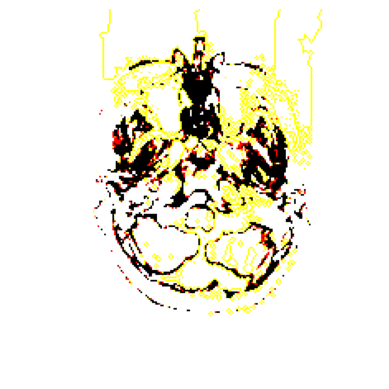

In [41]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/Users/praneetgogoi/Documents/brain-mri-model/vgg16.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train/fukuyama_muscular_dystrophy/fukuyama_muscular_dystrophy_train_0000.jpg"
img = Image.open(img_path).resize((224, 224))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')

plt.show()

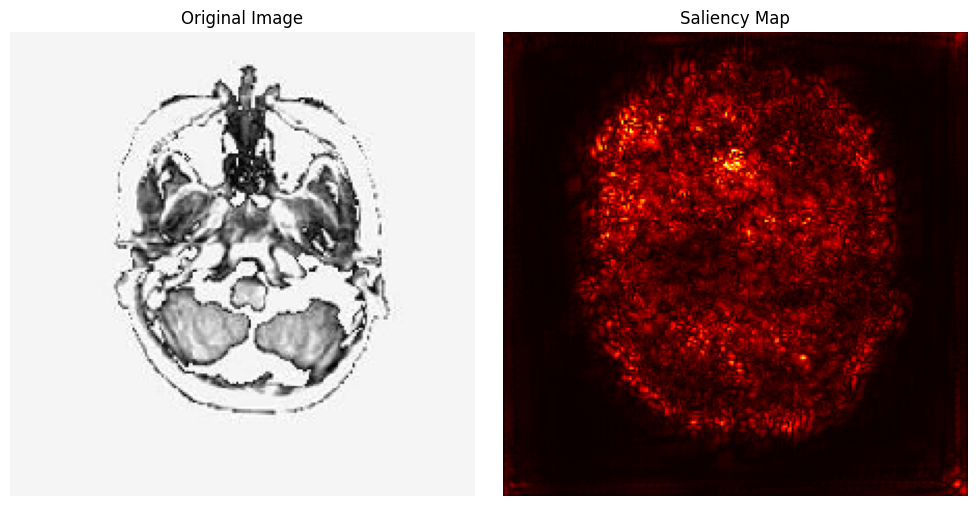

In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    return img_array

def compute_saliency_map(img_array):
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        predicted_class = tf.argmax(preds[0])
        loss = preds[0, predicted_class]

    grads = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    return saliency

def display_saliency_map(saliency, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0], cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.tight_layout()
    plt.savefig("saliency_map.png", dpi=300, bbox_inches="tight")
    plt.show()

img_path = '/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train/fukuyama_muscular_dystrophy/fukuyama_muscular_dystrophy_train_0000.jpg' 
img_array = load_and_preprocess_image(img_path)
saliency = compute_saliency_map(img_array)
display_saliency_map(saliency, img_path)